In [1]:
# %pip install matplotlib
# %pip install transformers
# %pip install umap-learn

In [2]:
import logging
import sys
from textwrap import TextWrapper

import torch
import torch.nn.functional as F

import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import torch
import transformers
from IPython.display import set_matplotlib_formats

transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# display all outputs from Jupyter notebook cells, not just last.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\eshaipuka\AppData\Local\miniconda3\envs\ai-sandbox\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

c:\Users\eshaipuka\AppData\Local\miniconda3\envs\ai-sandbox\Lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [6]:
import pandas as pd

emotions.set_format(type="pandas")

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df = train_ds[:]
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: ylabel='label_name'>

Text(0.5, 1.0, 'Frequency of Classes')

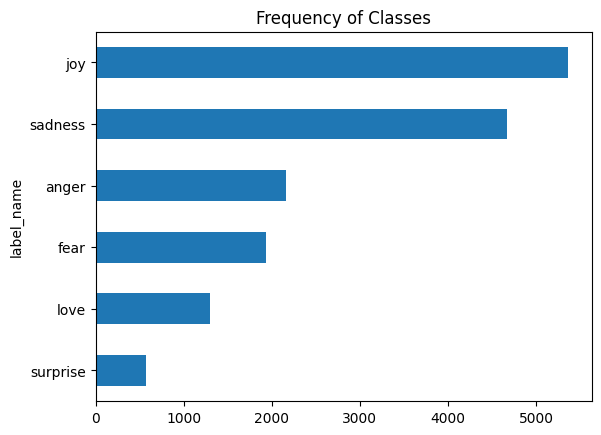

In [7]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the `joy` and `sadness` classes appear frequently, whereas `love` and `surprise` are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:

* Randomly oversample the minority class.
* Randomly undersample the majority class.
* Gather more labeled data from the underrepresented classes.

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

Text(0.5, 0.98, '')

Text(0.5, 0, '')

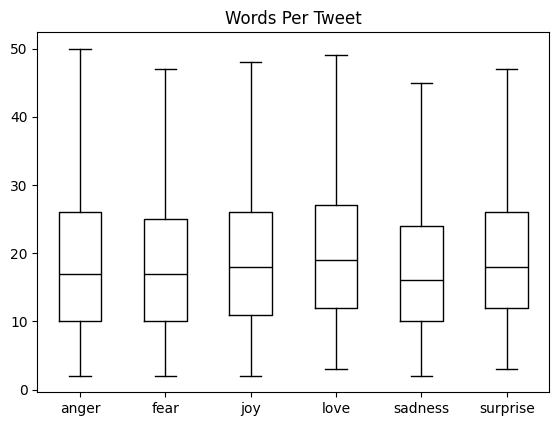

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [9]:
emotions.reset_format()

In [10]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
text = "Core task of NLP is to understand human language"
encoded_text = tokenizer(text)
encoded_text
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens
tokenizer.convert_tokens_to_string(tokens)
tokenizer.vocab_size
tokenizer.model_max_length
tokenizer.model_input_names

{'input_ids': [101, 4563, 4708, 1997, 17953, 2361, 2003, 2000, 3305, 2529, 2653, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

['[CLS]',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 'is',
 'to',
 'understand',
 'human',
 'language',
 '[SEP]']

'[CLS] core task of nlp is to understand human language [SEP]'

30522

512

['input_ids', 'attention_mask']

In [12]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map: 100%|██████████| 2000/2000 [00:00<00:00, 8934.53 examples/s]


In [13]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [14]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

Input tensor shape: torch.Size([1, 6])
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [15]:
outputs.last_hidden_state.size()
outputs.last_hidden_state[:,0].size()

torch.Size([1, 6, 768])

torch.Size([1, 768])

In [16]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden st  ates
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map: 100%|██████████| 2000/2000 [01:26<00:00, 23.15 examples/s]


In [17]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

((16000, 768), (2000, 768))

,X,Y,label
0,4.547830,7.316590,0
1,-2.981806,6.462958,0
2,5.370808,3.794519,3
3,-2.155726,4.630008,2
4,-3.282297,4.580949,3


Text(0.5, 1.0, 'sadness')

([], [])

Text(0.5, 1.0, 'joy')

([], [])

Text(0.5, 1.0, 'love')

([], [])

Text(0.5, 1.0, 'anger')

([], [])

Text(0.5, 1.0, 'fear')

([], [])

Text(0.5, 1.0, 'surprise')

([], [])

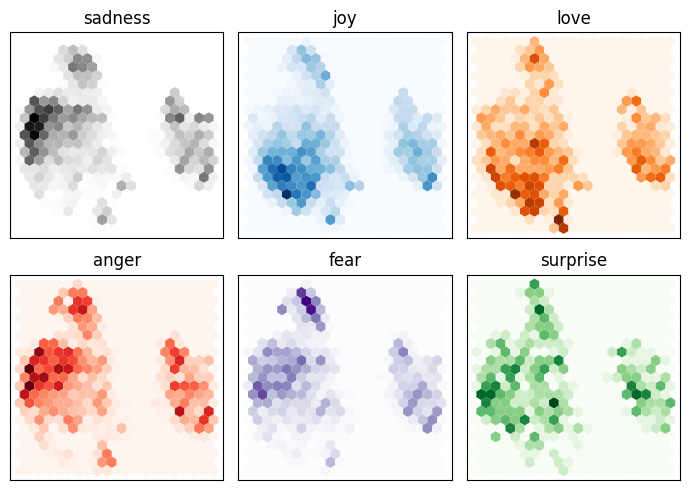

In [50]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

# from umap import UMAP
from umap import umap_ as UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP.UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()


fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [51]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [52]:
lr_clf.score(X_valid, y_valid)

0.634

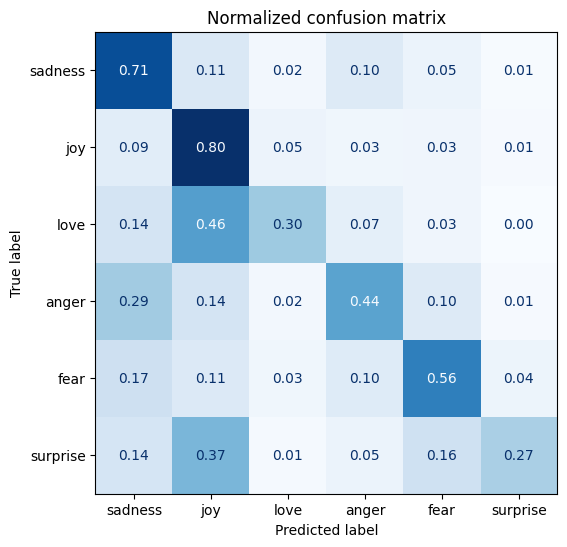

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)